# Masking

xarray supports masking usimg the `.where` operator. This can be used to mask a `DataArray` by itself, by it's coordinates, or by another `DataArray` with matching coordinates.

**Note:** This notebook has been updated to include proper weighting of spatial averages

Import the required libraries

In [1]:
import xarray
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

Open the surface air temperature dataset and assign `tas` to point to the data variable `tas` within the xarray `Dataset` `ds`.

In [3]:
ds = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/mon/atmos/Amon/r1i1p1/latest/tas/tas_Amon_ACCESS1-3_historical_r1i1p1_185001-200512.nc')
tas = ds.tas

As a trivial first example mask `tas` with itself. For clarity a variable, `tas0`, is defined, It is the first time slice of `tas`. Then `tas0` is used to mask itself and only plot temperatures between 270K and 295K.

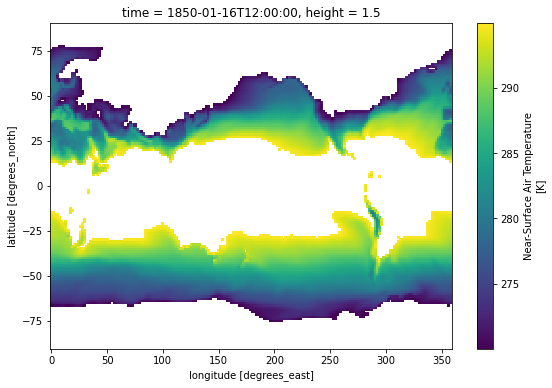

In [4]:
tas0 = tas.isel(time=0)
tas0.where(tas0>270).where(tas0<295).plot(size=6);

The mask can be applied to any time in the `tas` `DataArray`, or even the whole array. xarray will automatically broadcast along a missing dimension. To show how it works `tas0` is used as the mask criteria for a different time point in `tas`. The colourbar shows the plotted data contains values outside the range of the mask, as the mask is based on criteria from a different time point.

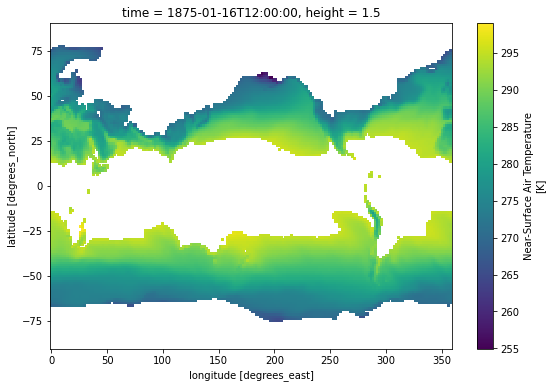

In [5]:
tas.where(tas0>270).where(tas0<295).isel(time=300).plot(size=6);

Coordinates can be used to mask as well. This is not a very useful example, but it does show clearly what is happening. This is different to using `sel`, as the data retains the same size dimensions, but fills the masked areas with missing values. It also shows that `where` can take a second argument, which, if supplied, is used as the fill value for the masked regions. Below the first plot `where` fills masked regions with a constant, `240`, and the second plot the `where` fills the masked area with a different time slice from `tas`

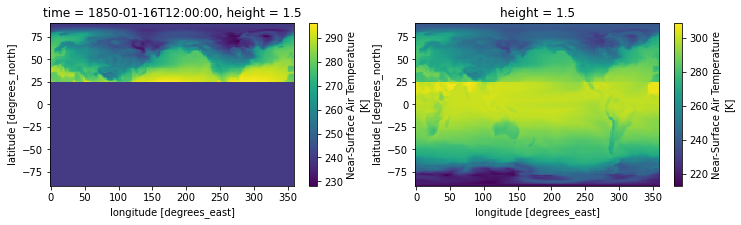

In [6]:
fig, axes = plt.subplots(ncols=2,figsize=(12,3))
tas0.where(tas0.lat>25, 240).plot(ax=axes[0])
tas0.where(tas0.lat>25, tas.isel(time=6)).plot(ax=axes[1]);

It is possible to mask a `DataArray` with another different `DataArray`. In the same collection that contains the near surface air temperature data there is also a netCDF file which contains the land surface fration data. The variable name is `sftlf`, which is difficult to type and understand, so it will be assigned to `landfrac`. Notice below that the variable was referenced directly from the `open_dataset` call.

In [ ]:
url = 'http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/fx/atmos/fx/r0i0p0/latest/sftlf/sftlf_fx_ACCESS1-3_historical_r0i0p0.nc'
landfrac = xarray.open_dataset(url).sftlf

Ocean is where the land area fraction is zero, so this can be used to mask the data and only calculate metrics over land (or ocean)

In [ ]:
tas.isel(time=0).where(landfrac>0).plot(size=8);

The calculations of anomalies from a climatology can be calculated as before

In [ ]:
tas_clim = tas.sel(time=slice('1960-01','1989-12')).mean(dim='time')
tas_anom = (tas - tas_clim)

In [ ]:
tas_anom_yearly = tas_anom.sel(time=slice('1960-01',None)).resample(time='Y').mean(dim='time')

Also as before, calculating the mean anomalogy by year and averaging over all points, but the calculation can be performed over land and ocean separately using `where`,

**Update:** An operation which combines grid cells of different size is not scientifically valid unless each cell is weighted by the size of the grid cell. xarray has a convenient [weighted](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.weighted.html) method to accomplish this
First need to load the cell area data for this model

First need to load the cell area data for this model

In [ ]:
areacella = xarray.open_dataset('http://dapds00.nci.org.au/thredds/dodsC/rr3/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/fx/atmos/fx/r0i0p0/latest/areacella/areacella_fx_ACCESS1-3_historical_r0i0p0.nc').areacella
areacella

Now use `where` to plot the area weighted anomalies over land, ocean and global

In [ ]:
tas_anom_yearly.where(landfrac>0).weighted(areacella).mean(dim=('lat','lon')).plot(size=8, label='Land only')
tas_anom_yearly.where(landfrac==0).weighted(areacella).mean(dim=('lat','lon')).plot(label='Ocean only')
tas_anom_yearly.mean(dim=('lat','lon')).plot(label='Global')
plt.legend();